# $\Delta$LEU ARG$^+$ Monoculture Model
Authors: Daniel Strohmeier, Stephan Noack (2022) 

### Assumptions


* Continuity
* Population average considered
* Ideally mixed reactor
* No oxygen or secondary substrate limitations (except auxotrophic amino acids)
* Uptake rates obey a Monod-type kinetic
* Secretion rates are lumped rates over the amino acid synthesis reactions and the transport to the bulk phase
* The substrate specific biomass yield $Y_{SX}^{dL}$ is the same as of the lysine-producer strain *C. glutamicum ATCC 17965 - Kjeldesen 2008*
* Constant and known specific volume of bacteria
* No maintenance metabolism considered


### Used Packages

* pyFOOMB - *Hemmerich 2021*
* Numpy
* Pandas
* joblib
* os

### Import of Required Libraries

In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import TimeSeries
from pyfoomb import Helpers
from pyfoomb import Measurement
from pyfoomb import ObservationFunction
from pyfoomb import ParameterMapper
import joblib
import os.path

import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
numpy.random.seed(123)

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


# 1. Bioprocess model

## Kinetics

### Monod Kinetic for Growth on 2 Substrates 

$$
\begin{align}
    \large[1]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}}\cdot\frac{A}{A+K_{A}}, 
    \\ \\ S\in \{S_{dA,in}, S_{dL,in}\}, \\
    A\in \{Arg_{dA,in}, Leu_{dL,in}\}
\end{align}
$$

*used for:*  
* $mu\_dL$

### Classical Monod Kinetic for Uptake and Sythesis Rates 
$$
\begin{align}
    \large[2]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}},\\
\end{align}
$$

*used for:*
* $v\_upt\_Leu\_dL$ 
* $v\_upt\_S\_dL$
* $v\_syn\_Arg\_dL$


## Balances

$\large[3] :\frac{dX_{\Delta LeuArg^{+}}}{dt} = \mu_{\Delta LeuArg^{+}} \cdot X_{\Delta LeuArg^{+}}$ 


$\large[4] :\frac{dS_{\Delta LeuArg^{+}}^{[in]}}{dt} = v_{upt,\Delta LeuArg^{+}}^{[S]} - \mu_{\Delta LeuArg^{+}} \cdot \frac{Y_{S/X,\Delta LeuArg^{+}}}{V_{Cell}} - v_{syn,\Delta LeuArg^{+}}^{[Arg]} - \mu_{\Delta LeuArg^{+}} \cdot S_{\Delta LeuArg^{+}}^{[in]}$


$\large[5] :\frac{dLeu_{\Delta LeuArg^{+}}^{[in]}}{dt} = v_{upt,\Delta LeuArg^{+}}^{[Leu]} - \mu_{\Delta LeuArg^{+}} \cdot \frac{Y_{Leu/X,\Delta LeuArg^{+}}}{V_{Cell}} - \mu_{\Delta LeuArg^{+}} \cdot Leu_{\Delta LeuArg^{+}}^{[in]}$


$\large[10]:\frac{dS^{[ex]}}{dt} = - v_{upt,\Delta LeuArg^{+}}^{[S]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}}$


$\large[11]:\frac{dArg^{[ex]}}{dt} = v_{syn,\Delta LeuArg^{+}}^{[Arg]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}} $


$\large[12]:\frac{dLeu^{[ex]}}{dt} = -  v_{upt,\Delta LeuArg^{+}}^{[Leu]}\cdot V_{Cell}\cdot X_{\Delta LeuArg^{+}}$


In [2]:
# Defines the model class
class BatchModel(BioprocessModel): 
     
    def specific_growth_rate_mu(self, S_in, A1_in):        
        mu_max = self.model_parameters['mu_max_dL']
        K_mu_S = self.model_parameters['K_mu_S_dL']
        K_mu_A1 = self.model_parameters['K_mu_Leu_dL']
        mu = mu_max * S_in / (K_mu_S + S_in) * A1_in / (K_mu_A1 + A1_in)
        return mu        
    
    def specific_substrate_uptake_rate_v_upt_S(self, S_ex):
        v_upt_S_max = self.model_parameters['v_upt_S_max_dL']
        K_upt_S = self.model_parameters['K_upt_S_dL']
        v_upt_S = v_upt_S_max * S_ex / (K_upt_S + S_ex)
        return v_upt_S
    
    def specific_aminoacid_uptake_rate_v_upt_A1(self, A1_ex):
        v_upt_A1_max = self.model_parameters['v_upt_Leu_max_dL']
        K_upt_A1 = self.model_parameters['K_upt_Leu_dL']
        v_upt_A1 = v_upt_A1_max * A1_ex / (K_upt_A1 + A1_ex)
        return v_upt_A1 
    
    def specific_aminoacid_synthesis_rate_v_syn_A2(self, S_in):
        v_syn_A2_max = self.model_parameters['v_syn_Arg_max_dL']
        K_syn_S = self.model_parameters['K_syn_Arg_dL']
        v_syn_A2 = v_syn_A2_max * S_in / (K_syn_S + S_in)
        return v_syn_A2    

    def rhs(self, t, y, sw):        
        
        # Unpack the state vector. The states are alphabetically ordered.
        Arg_ex, Leu_dL_in, Leu_ex, S_dL_in, S_ex, X_dL = y
        
        # Unpack model parameters
        Y_S_X_dL   = self.model_parameters['Y_S_X_dL']
        Y_Leu_X_dL = self.model_parameters['Y_Leu_X_dL']
        V_cell     = self.model_parameters['V_cell']
        
        # Calculate specific rates
        mu_dL        = self.specific_growth_rate_mu(S_dL_in, Leu_dL_in)        
        v_upt_S_dL   = self.specific_substrate_uptake_rate_v_upt_S(S_ex)
        v_upt_Leu_dL = self.specific_aminoacid_uptake_rate_v_upt_A1(Leu_ex)
        v_syn_Arg_dL = self.specific_aminoacid_synthesis_rate_v_syn_A2(S_dL_in)
       
        # Calculate state derivatives        
        dX_dLdt      =   mu_dL        * X_dL        
        dS_exdt      = - v_upt_S_dL   * V_cell * X_dL
        dLeu_exdt    = - v_upt_Leu_dL * V_cell * X_dL
        dArg_exdt    =   v_syn_Arg_dL * V_cell * X_dL
        
        dS_dL_indt   =   v_upt_S_dL   - mu_dL  * Y_S_X_dL   / V_cell - v_syn_Arg_dL - mu_dL * S_dL_in
        dLeu_dL_indt =   v_upt_Leu_dL - mu_dL  * Y_Leu_X_dL / V_cell - mu_dL * Leu_dL_in
                
        # Return list of state derivatives in the same order as the state vector was unpacked
        return [dArg_exdt, dLeu_dL_indt, dLeu_exdt, dS_dL_indt, dS_exdt, dX_dLdt]    
   
    # Defines discrete switches that are activated when event_* becomes zero
    def state_events(self, t, y, sw):
        
        Arg_ex, Leu_dL_in, Leu_ex, S_dL_in, S_ex, X_dL = y
        
        # To prevent that these states become negative they are monitored
        event_S_ex   = S_ex
        event_A1_ex  = Leu_ex         
        event_S_in   = S_dL_in
        event_A1_in  = Leu_dL_in
        
        events = [event_S_ex, event_A1_ex, event_S_in, event_A1_in]
        
        return events
    
    # Changes states if switch is active
    def change_states(self, t, y, sw):
        
        Arg_ex, Leu_dL_in, Leu_ex, S_dL_in, S_ex, X_dL = y

        if sw[0]:
            S_ex      = 0
        if sw[1]:
            Leu_ex    = 0
        if sw[2]:
            S_dL_in   = 0            
        if sw[3]:
            Leu_dL_in = 0
            
        return [Arg_ex, Leu_dL_in, Leu_ex, S_dL_in, S_ex, X_dL]
    
    # Enables calculation of specific rates 
    def get_specific_rates_time_series(self, model_states:list):
        
        # Use the pyFOOMB Helpers method to get a specific TimeSeries object, specified by its `name` and `replicate_id`        
        state_GLC_ex = Helpers.extract_time_series(model_states, name='S_ex',      replicate_id=self.replicate_id)
        state_LEU_ex = Helpers.extract_time_series(model_states, name='Leu_ex',    replicate_id=self.replicate_id) 
        state_GLC_in = Helpers.extract_time_series(model_states, name='S_dL_in',   replicate_id=self.replicate_id)
        state_LEU_in = Helpers.extract_time_series(model_states, name='Leu_dL_in', replicate_id=self.replicate_id)        
                
        # Get the timepoints and values needed for specific rate calculation
        _t = state_GLC_ex.timepoints        
        _GLC_ex = state_GLC_ex.values
        _LEU_ex = state_LEU_ex.values 
        _GLC_in = state_GLC_in.values
        _LEU_in = state_LEU_in.values   
       
                
        # Calculate specific rates vectors
        _mu        = self.specific_growth_rate_mu(_GLC_in, _LEU_in)       
        _v_upt_GLC = self.specific_substrate_uptake_rate_v_upt_S(_GLC_ex)
        _v_upt_LEU = self.specific_aminoacid_uptake_rate_v_upt_A1(_LEU_ex)
                
        # Create new corresponding TimeSeries objects
        mu        = TimeSeries(name='mu',        replicate_id=self.replicate_id, timepoints=_t, values=_mu)        
        v_upt_GLC = TimeSeries(name='v_upt_GLC', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_GLC)        
        v_upt_LEU = TimeSeries(name='v_upt_ARG', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_LEU)        
        
        return [mu, v_upt_GLC, v_upt_LEU]    

# Defining initial parameters (parameters are esimated in section 5.)    
model_parameters = {       
    'mu_max_dL'        : 0.4072643376836091,    # [1/h]
    'K_mu_S_dL'        : 0.0019124787153479942, # [mmol/L_cell]    
    'K_mu_Leu_dL'      : 0.0025226633703546737, # [mmol/L_cell]
    'v_upt_S_max_dL'   : 2962.0766872079653,    # [mmol/g_X/h] --> [mmol/L_cell/h]
    'v_upt_Leu_max_dL' : 165.26300403350118,    # [mmol/g_X/h] --> [mmol/L_cell/h]
    'v_syn_Arg_max_dL' : 0,                     # [mmol/L_cell/h]
    'K_upt_S_dL'       : 0.004197966680690081,  # [mmol/L_reactor]
    'K_upt_Leu_dL'     : 0.0020848622244192044, # [mmol/L_reactor]
    'K_syn_Arg_dL'     : 0.06839726849968554,   # [mmol/L_cell]
    'Y_S_X_dL'         : 10.5976 - 0.3477,      # [mmol/g_X]
    'Y_Leu_X_dL'       : 0.3477,                # [mmol/g_X]  
    'V_cell'           : 1.93/1000,             # [L_cell/g_X]     
}     

# Defining initial values (S_ex0, Leu_ex0, X_dA0 are estimated for each replicate [3.] in section 5.)
initial_values = {
    'S_ex0'            : 100, # [mM]
    'S_dL_in0'         : 0.0, # [mM]
    'Leu_ex0'          : 3,   # [mM]
    'Leu_dL_in0'       : 0.0, # [mM]
    'Arg_ex0'          : 0.0, # [mM] 
    'X_dL0'            : 0.1, # [g/L]    
}  

# 2. Definition of Observation Functions

In [3]:
# Defines an observation function class, that inherits from `ObservationFunction`.
# It must implement the method `observe`, taking model values as input, returning the corresponding observation.
class BS(ObservationFunction):

    def observe(self, model_values):
        # parameter unpacking
        a = self.observation_parameters['a']
        b = self.observation_parameters['b']
        return (model_values + b) / a
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_bs = {
    'observed_state' : 'X_dL',
    'a' : 0.11127987086921534,    
    'b' : 1.0530490911410222,
}

class GLC_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_glc = {
    'observed_state' : 'S_ex',
}

class LEU_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_leu = {
    'observed_state' : 'Leu_ex',
}

class ARG_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_arg = {
    'observed_state' : 'Arg_ex',
}

# Creates a list, containing the tuples of ObservationFunction subclasses and their parameter dictionaries
observations_functions = [
    (BS, observation_parameters_bs), 
    (GLC_mM, observation_parameters_glc),
    (ARG_mM, observation_parameters_arg),
    (LEU_mM, observation_parameters_leu),
]

# 3. Instatiate Caretaker

In [4]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=BatchModel, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    observation_functions_parameters=observations_functions,
    replicate_ids=['1st', '2nd', '3rd'],
    initial_switches=[False]*4,
)

In [5]:
# Create parameter mappings for the replicate_ids
mappings = [
    ParameterMapper(replicate_id='1st', global_name='X_dL0', local_name='X0_R1', value=0.008847710650708248),
    ParameterMapper(replicate_id='2nd', global_name='X_dL0', local_name='X0_R2', value=0.006201497861267161),
    ParameterMapper(replicate_id='3rd', global_name='X_dL0', local_name='X0_R3', value=0.007432364256016957),    
    ParameterMapper(replicate_id='1st', global_name='S_ex0', local_name='GLC0_R1', value=57.41812106982615),
    ParameterMapper(replicate_id='2nd', global_name='S_ex0', local_name='GLC0_R2', value=50.742288741152095), 
    ParameterMapper(replicate_id='3rd', global_name='S_ex0', local_name='GLC0_R3', value=52.91286896826489),
    ParameterMapper(replicate_id='1st', global_name='Leu_ex0', local_name='LEU0_R1', value=2.1322792565652904),
    ParameterMapper(replicate_id='2nd', global_name='Leu_ex0', local_name='LEU0_R2', value=2.326034816375667), 
    ParameterMapper(replicate_id='3rd', global_name='Leu_ex0', local_name='LEU0_R3', value=1.9929264178214474),     
]

# Applies the mappings
caretaker.apply_mappings(mappings)

# 4. Include Experimental Data

In [6]:
df_dict = pandas.read_excel('Monoculture_dLEU_ARG+_data.xlsx', header=[0, 1], index_col=0, sheet_name=None)

In [7]:
# Define linear error model

def linear_error_model(values, error_parameters:dict):
    slope = error_parameters['slope']
    offset = error_parameters['offset']
    return values*slope + offset

error_parameters = {
    'slope' : 0.05,
    'offset' : 0.01,
}

In [8]:
# Create an empty list, which will collect all Measurement objects
data = []

# Iterate over replicates
for _replicate_id in df_dict.keys():
    _df = df_dict[_replicate_id]
    names = numpy.unique([mi[0] for mi in _df.columns])
    for name in names:
        # Create corresponding Measurement object
        _measurement = Measurement(
            name=name, 
            replicate_id = _replicate_id,  
            timepoints=_df.index, 
            values=_df[(name, 'values')].to_numpy(),             
            error_model=linear_error_model,
            error_model_parameters=error_parameters            
        )
        # Append to list
        data.append(_measurement) 

# 5. Parameter Estimation

In [9]:
unknowns_and_bounds = {
 'X0_R1'            : (0.008946388224615342, 0.010934474496752083 ),
 'X0_R2'            : (0.006304736367729321, 0.007705788893891392 ),
 'X0_R3'            : (0.007584042956128079, 0.009269385835267652 ),
 'GLC0_R1'          : (51.24205564143393   , 62.62917911730814    ),
 'GLC0_R2'          : (45.727053687677724  , 55.888621173828334   ),
 'GLC0_R3'          : (47.671470582736035  , 58.26513071223294    ),
 'LEU0_R1'          : (1.9361698856108167  , 2.3664298601909985   ),
 'LEU0_R2'          : (2.1084601078762613  , 2.5770067985154306   ),
 'LEU0_R3'          : (1.8095666414610903  , 2.2116925617857772   ),
 'mu_max_dL'        : (0.3574411203392393  , 0.43687248041462584  ),
 'K_mu_S_dL'        : (0.002270232783535148, 0.00277472895765407  ),
 'K_mu_Leu_dL'      : (0.002398922595185127, 0.002932016505226266 ),
 'v_upt_S_max_dL'   : (2670.5265693560827  , 3263.976918101879    ),
 'v_upt_Leu_max_dL' : (149.79802454655106  , 183.08647444578466   ),
 'K_upt_S_dL'       : (0.003071755379934231, 0.0037543676865862824),
 'K_upt_Leu_dL'     : (0.002032928201758464, 0.002484690024371456 ),
 'a'                : (0.09876320219560175 , 0.12071058046129103  ),
 'b'                : (0.928087830481992   , 1.1343295705891014   )}

In [10]:
optimizers = ['de1220', 'ihs', 'simulated_annealing', 'pso']  # Specifies used optimizers
mult = int(joblib.cpu_count()/len(optimizers))                # expands optimizer list, such that all CPUs are used
rtol = 1e-3                                                   # Defines relative tolerance between islands for conv.
runs = 1                                                      # Specifies number of runs/parameter bound changes
evolutions = 5                                                # Specifies max. number of model evoultions
max_evotime = 5                                               # Specifies max. allowed time for all evolutions [min]

In [11]:
estimates_coll = {}
diff = []
for j in range(1,runs+1):
    estimates, est_info = caretaker.estimate_parallel(
        unknowns=list(unknowns_and_bounds.keys()), 
        bounds=list(unknowns_and_bounds.values()), 
        measurements=data, 
        report_level=3,
        optimizers=optimizers*mult,
        max_evotime_min=max_evotime,
        rtol_islands=rtol,
        evolutions=evolutions
        )
    print('Adjust parameter bounds\n')
    for i, _par in enumerate(unknowns_and_bounds):
        estimates_coll[_par]=estimates[_par]
        #unknowns_and_bounds[_par]=(estimates[_par]*0.5, estimates[_par]*1.5)
        
        diff = (_par, (estimates[_par]-unknowns_and_bounds[_par][0])/
                (unknowns_and_bounds[_par][1]-unknowns_and_bounds[_par][0]))
              
        if (diff[1] < 0.05) or (diff[1] > 0.95):
            unknowns_and_bounds[_par]=(estimates[_par]*0.5, estimates[_par]*1.5)
        else:
            unknowns_and_bounds[_par]=(estimates[_par]*0.9, estimates[_par]*1.1)

Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:   11.3s remaining:   57.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   12.0s finished


Running 5 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 1-------------
Current best loss: 242.70841876594247
Average loss among the islands: 345.343502 +/- 120.493181 (34.890820 %)
-------------Finished evolution 2-------------
Current best loss: 241.58112755081814
Average loss among the islands: 330.879945 +/- 127.428531 (38.512014 %)
-------------Finished evolution 3-------------
Current best loss: 241.3644598261618
Average loss among the islands: 308.519824 +/- 107.858137 (34.959873 %)

Reached a stopping criterion after evolution 3:
convergence: False
max_runtime: False
max_evotime: True
max_memory_share: False

Estimated parameters:
a: 0.1160178621283123
b: 1.0964007094664967
GLC0_R1: 57.806558760410255
GLC0_R2: 51.22078379229222
GLC0_R3: 52.885053160430445
K_mu_Leu_dL: 0.0024599492349228996
K_mu_S_dL: 0.002572359137811948
K_upt_Leu_dL: 0.002055524193036126
K_upt_S_dL: 0.003621396482187654
LEU0_R1: 2.1316976073922174
LEU0_R2: 2.31982193201489

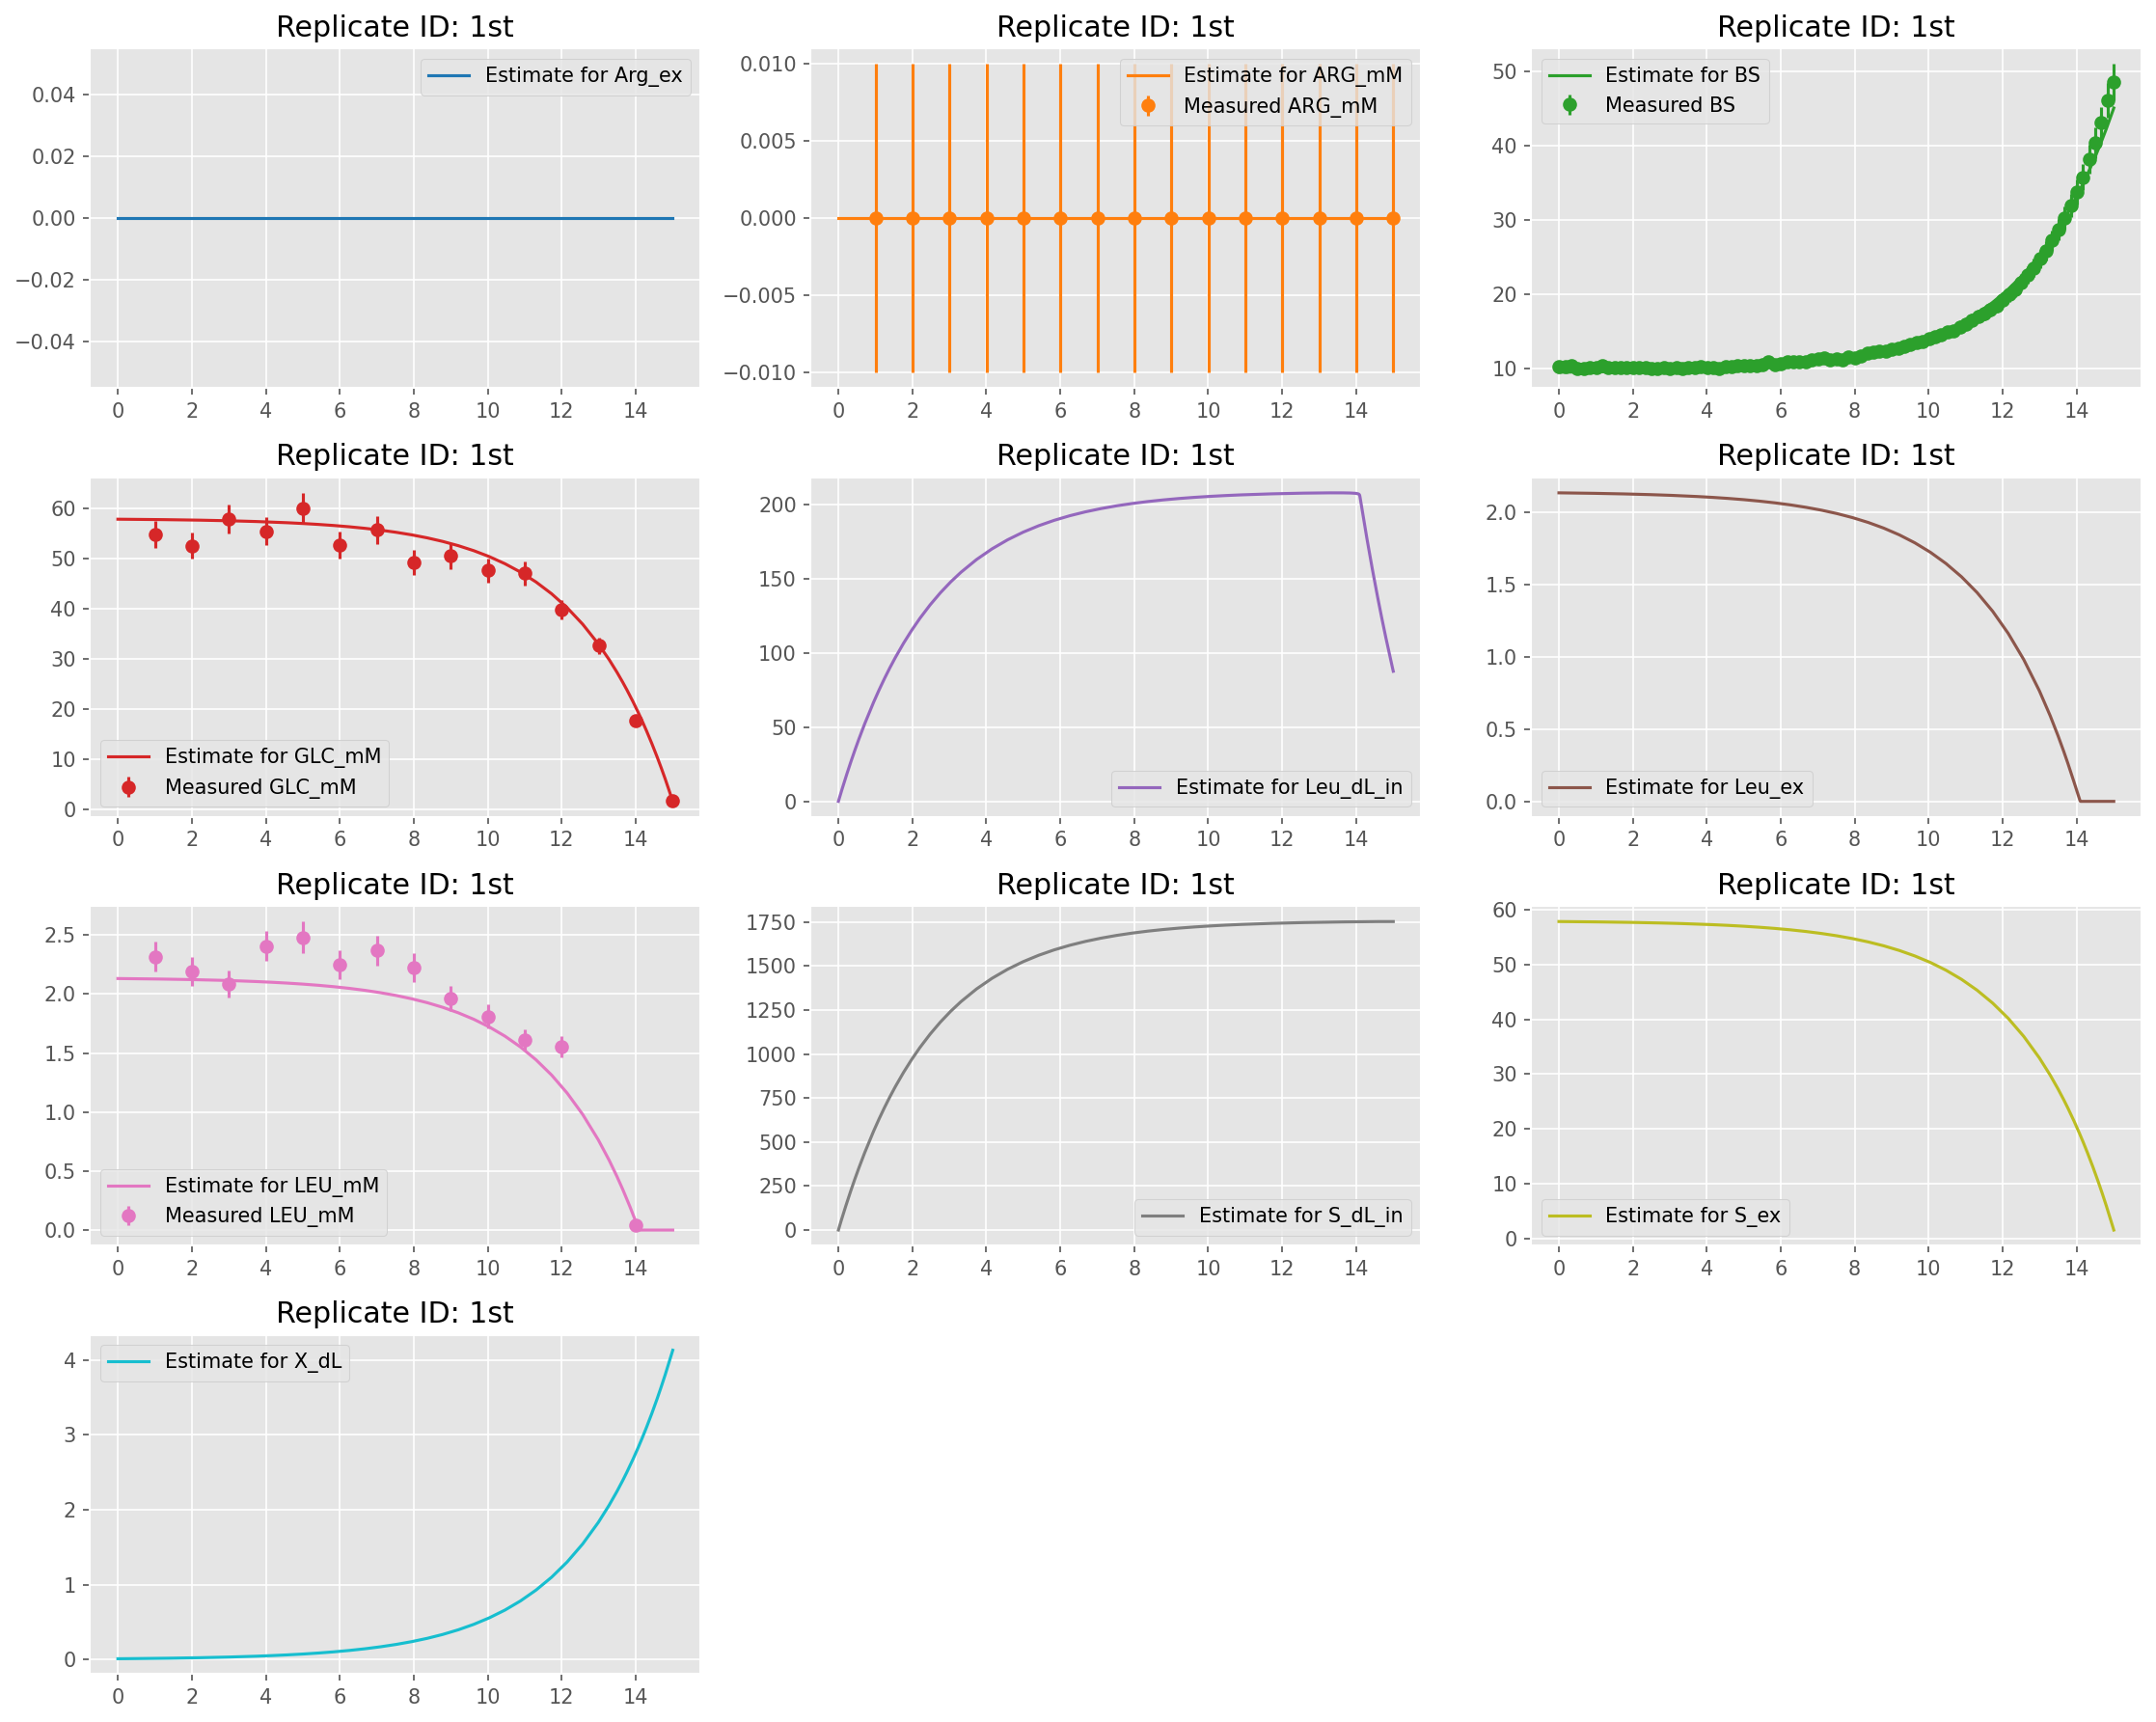

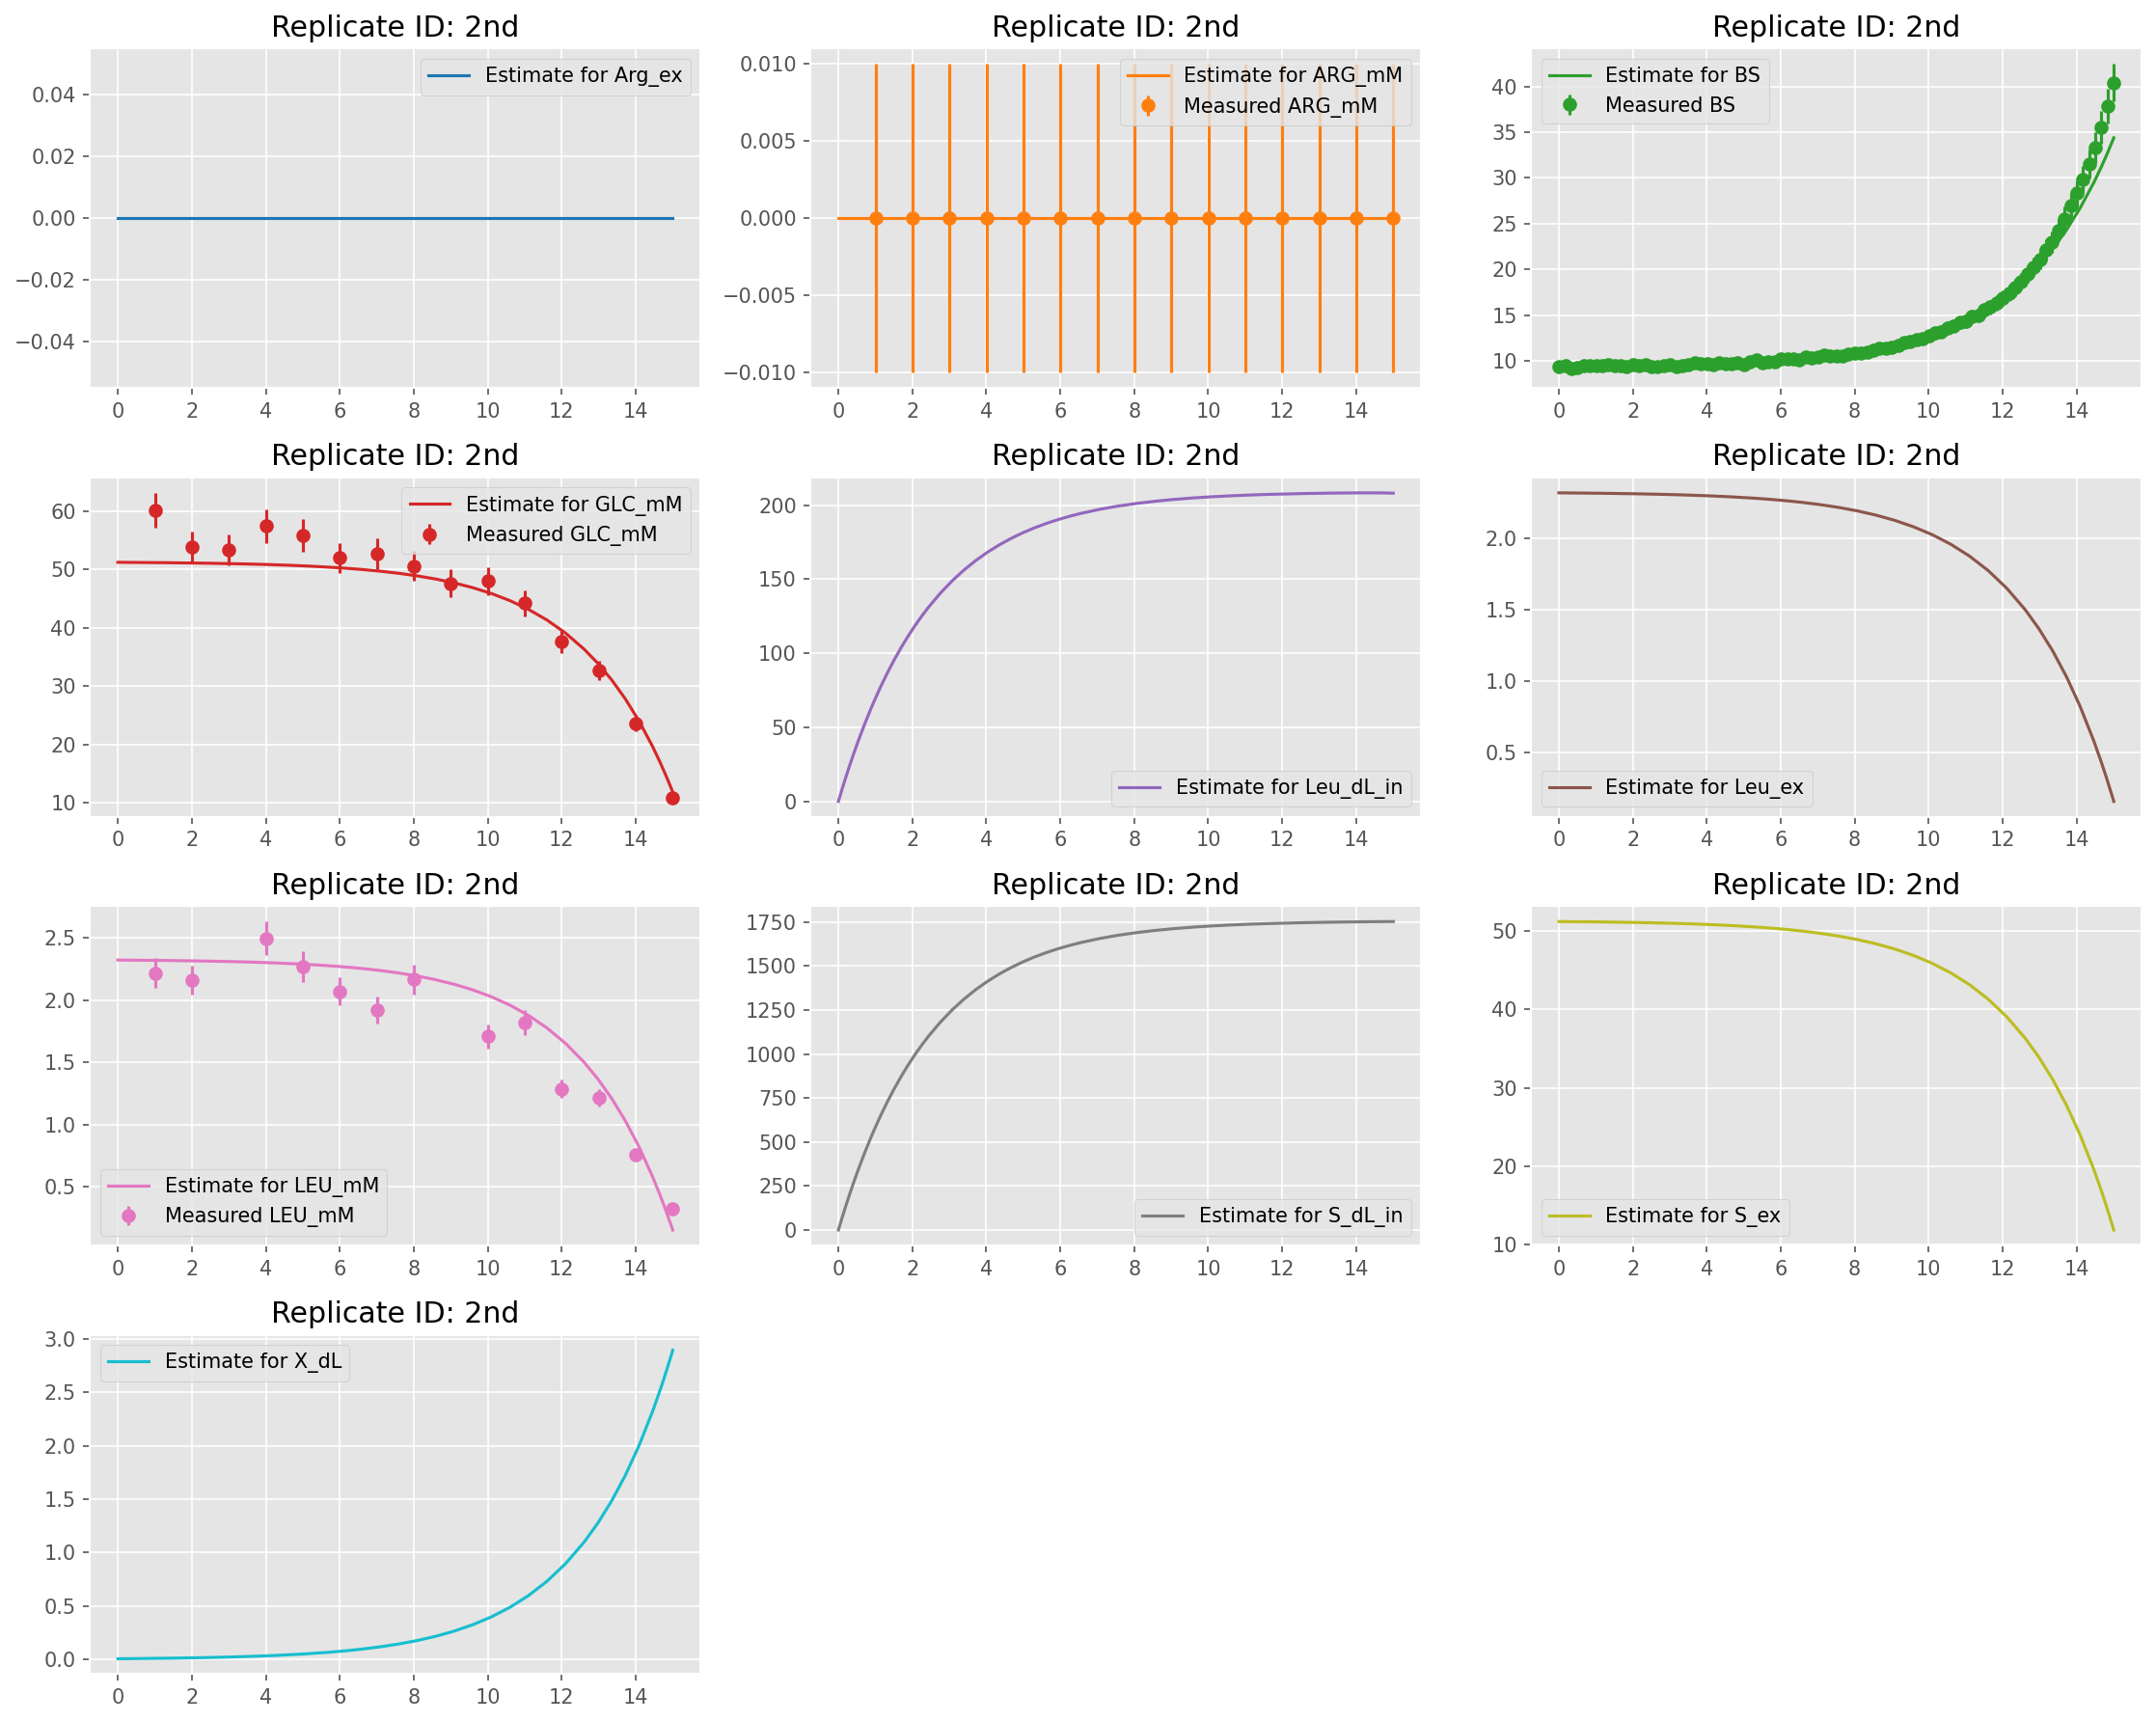

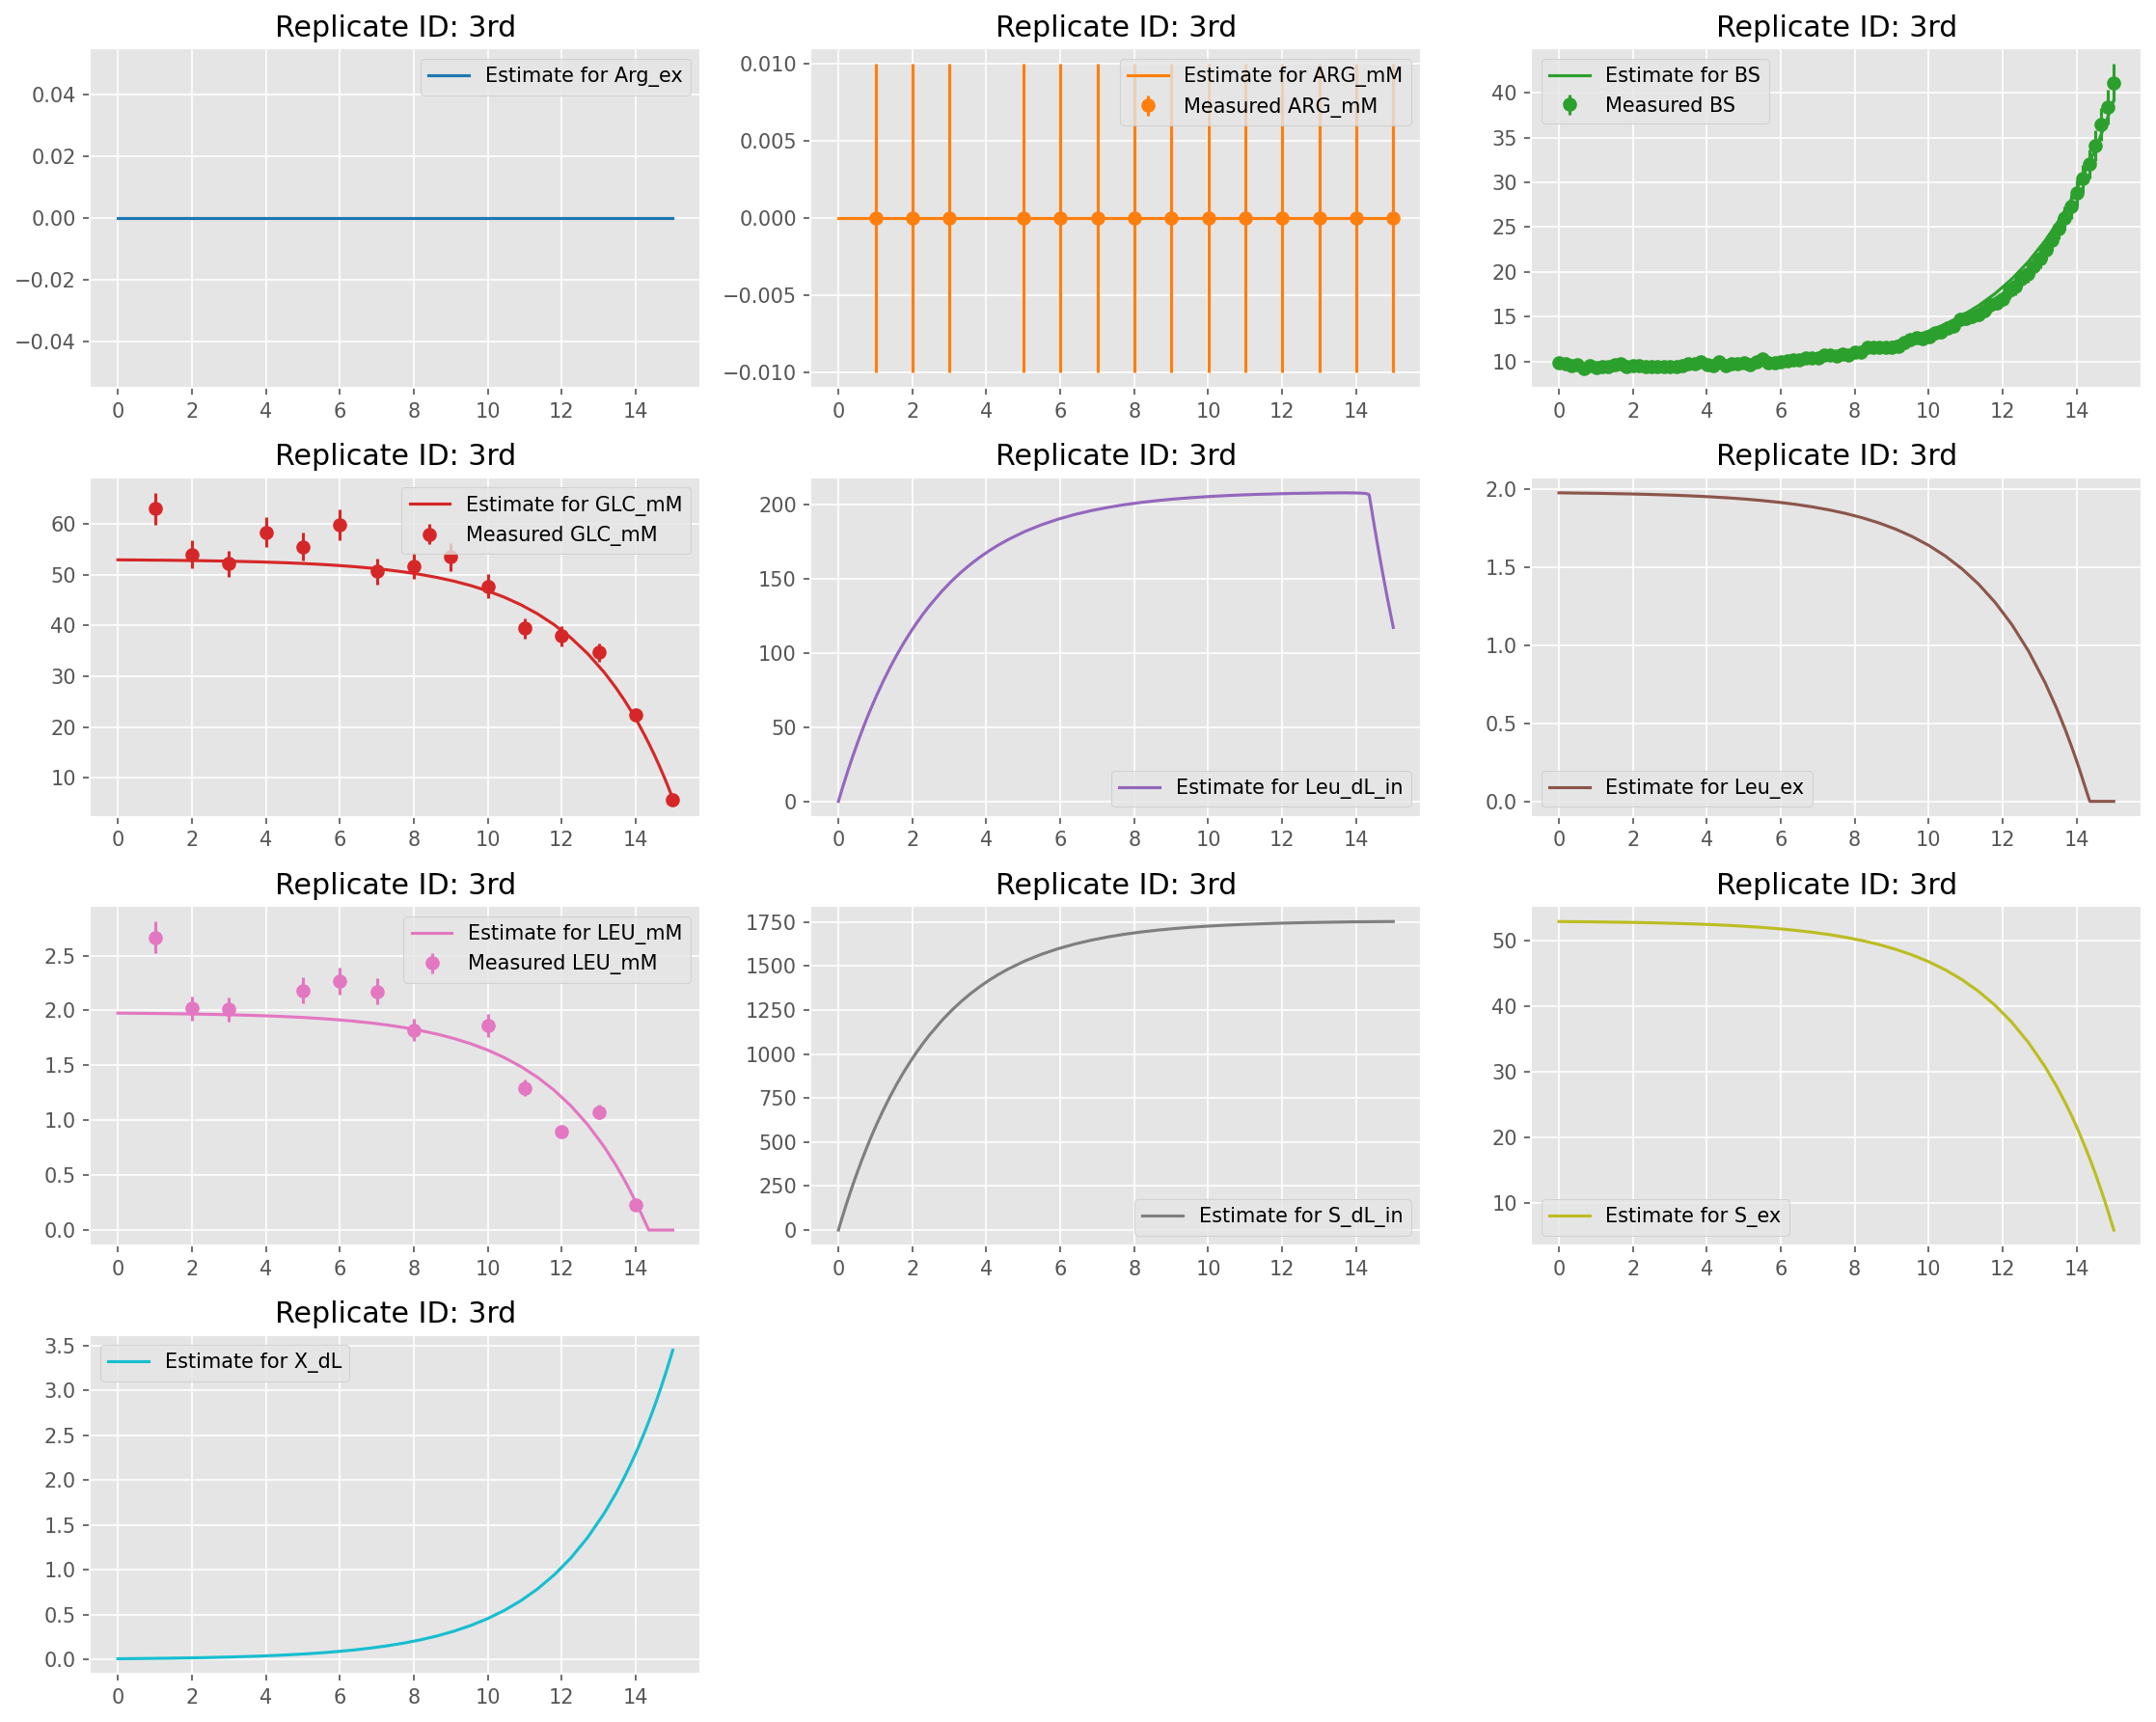

In [12]:
# Compare simulated data to experimental data
_fig4 = Visualization.compare_estimates(parameters=estimates, measurements=data, caretaker=caretaker)

# 6. Define Functions for Evaluation

In [19]:
def plot_rates(mc_data, conos=False, rates_only=True):
    # Distinguish plotsize if conos (more rates)
    if conos and rates_only:
        np = 4
    elif conos and (rates_only == False):
        np = 10
    elif (conos == False) and rates_only:
        np = 2
    else:
        np = 8

    # Initialize figure
    fig, ax_r = plt.subplots(np, 2)
    fig.set_size_inches(18, 4 * np)

    # Get rate-keys if specified
    if rates_only:
        rate_keys = [rate for rate in mc_data.keys() if (str(rate).startswith('v')) or (str(rate).startswith('mu'))]
    else:
        rate_keys = mc_data.keys()

    # initialize plot counters
    i, j = 0, 0

    # Plot all rates
    for rate_name in rate_keys:
        for r in mc_data[rate_name]:
            ax_r[i, j].plot(r[0], r[1], linewidth=0.1, color='red')
        ax_r[i, j].set_title(str(rate_name))
        ax_r[i, j].set_xlim(0, 18)
        ax_r[i, j].set_xlabel('Time [h]')
        if str(rate_name).startswith('mu'):
            ax_r[i, j].set_ylabel(str(rate_name)+ ' [1/h]')
        else:
            ax_r[i, j].set_ylabel(str(rate_name)+ ' [mmol/l_cell*h]')
        # ax_r[i,j].plot(get_mean(mc_data[rate_name]).index,get_mean(mc_data[rate_name]).values,linewidth=1.5, color='black')

        if j == 0:
            i, j = i, j + 1
        else:
            i, j = i + 1, 0
            
    plt.subplots_adjust(
        left     = 0.1,
        right    = 0.9,
        bottom   = 0.1,
        top      = 0.9,
        wspace   = 0.4,
        hspace   = 0.4,
        
    )
    
    
def rate2df(data, rate):
    # Read rate from data
    _data = data[rate]

    # Initialize dict
    _df_list = []

    # Iterate trough mc-samples to fill the list with dataframes
    try:
        for mc in range(len(_data)):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(len(_data))
    except:
        for mc in range(2, len(_data) - 2):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(2, len(_data) - 2)
    # concatenate dataframes & drop unmatching rows
    _df = pd.concat(_df_list, axis=1).dropna().transpose()

    # assign mc_samples as keys
    return _df.reset_index().drop('index', axis=1).transpose()


            
def conv2cell_unit(mc_data, rate: list = ['v_upt_GLC', 'v_upt_ARG','v_syn_LEU']):
                                          
    # Set constant conversion factor: specific cell volume
    V_cell = 1.93 / 1000

    # Initialize result list
    res = []

    # Substrate uptake dA
    if 'v_upt_GLC' in rate:
        v_upt_S_dA = rate2df(mc_data, 'v_upt_GLC')
        v_upt_S_dA = v_upt_S_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_S_dA)

    # Arginine uptake dA
    if 'v_upt_LEU' in rate:
        v_upt_Arg_dA = rate2df(mc_data, 'v_upt_LEU')
        v_upt_Arg_dA = v_upt_Arg_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_Arg_dA)

    # Arginine production dL
    if 'v_syn_ARG' in rate:
        v_syn_Leu_dA = rate2df(mc_data, 'v_syn_ARG')
        v_syn_Leu_dA = v_syn_Leu_dA.apply(lambda x: x * V_cell)
        res.append(v_syn_Leu_dA)

    return res

# 7. Monte Carlo Sampling

In [20]:
optimizers = ['sea', 'compass_search']         # Left out optimizers due to very slow convergence
mult       = 2                                 # Decrease mult to use CPU-Cores for parallel sample computing
evolutions = 40                                # Increase max. number of evolutions to ensure convergence
n_mc       = 30                                # Number of MC-samples produced (low number to aviod RAM overflow)

## 7.1 Calculate / Read MC-Samples

In [21]:
# Not run in script because of huge calculation time

#estimates = caretaker.estimate_parallel_MC_sampling(
#    unknowns=list(unknowns_and_bounds.keys()), 
#    bounds=list(unknowns_and_bounds.values()), 
#    measurements=data, 
#    report_level=5,
#    optimizers=optimizers*mult,
#    rtol_islands=rtol,
#    evolutions=evolutions,
#    mc_samples=n_mc,
#    )

# Export MC-samples to excel (enables clearing RAM and restarting)
#i=1
#while os.path.isfile('dLeuArg_MC_bkp'+str(i)+'.xlsx'):
#    i+=1
#    
#estimates.to_excel('dLeuArg_MC_bkp'+str(i)+'.xlsx')

In [22]:
# Import MC samples for evaluation (For supplement all created files were merged into one)
mc_samples = pandas.read_excel('Monoculture_dLEU_ARG+_results_MC.xlsx', index_col=0)

## 7.2 Calculate Rates for all MC-Samples

In [23]:
# Simulating rates for all MC samples
parameter_slices = Helpers.split_parameters_distributions(mc_samples)

# initialize list for saving simulations
sim_many         = []

# Fix timepoint-vector
t = numpy.linspace(0, 20, 400)

for _par in parameter_slices:
    # Set current parameters and run forward simulation
    caretaker.set_parameters(_par)
    _sim = caretaker.simulate(t=t, parameters=_par)

    # Now calculate all specific rates TimeSeries objects
    specific_rates = []
    for rid in caretaker.replicate_ids:
        specific_rates.extend(
            caretaker.simulators[rid].bioprocess_model.get_specific_rates_time_series(_sim)
        )

    simulation_extended = [*_sim, *specific_rates]
    sim_many.append(simulation_extended)

# Sort Data into RIDs
rep1 = {}
rep2 = {}
rep3 = {}

# Easier format for data handling 
for mcs in range(len(sim_many)):
    for rate in sim_many[mcs]:
        if rate.replicate_id == '1st':
            if rate.name not in rep1.keys():
                rep1[rate.name] = []
                rep1[rate.name].append([rate.timepoints, rate.values])
            else:
                rep1[rate.name].append([rate.timepoints, rate.values])
        if rate.replicate_id == '2nd':
            if rate.name not in rep2.keys():
                rep2[rate.name] = []
                rep2[rate.name].append([rate.timepoints, rate.values])
            else:
                rep2[rate.name].append([rate.timepoints, rate.values])
        if rate.replicate_id == '3rd':
            if rate.name not in rep3.keys():
                rep3[rate.name] = []
                rep3[rate.name].append([rate.timepoints, rate.values])
            else:
                rep3[rate.name].append([rate.timepoints, rate.values])

## 7.3 Convert Units

In [24]:
#Convert units to per gdw
dL1_c = conv2cell_unit(rep1)
dL1_c.append(rate2df(rep1,'mu'))
dL2_c = conv2cell_unit(rep2)
dL2_c.append(rate2df(rep2,'mu'))
dL3_c = conv2cell_unit(rep3)
dL3_c.append(rate2df(rep3,'mu'))

## 7.4 Plot all Rates

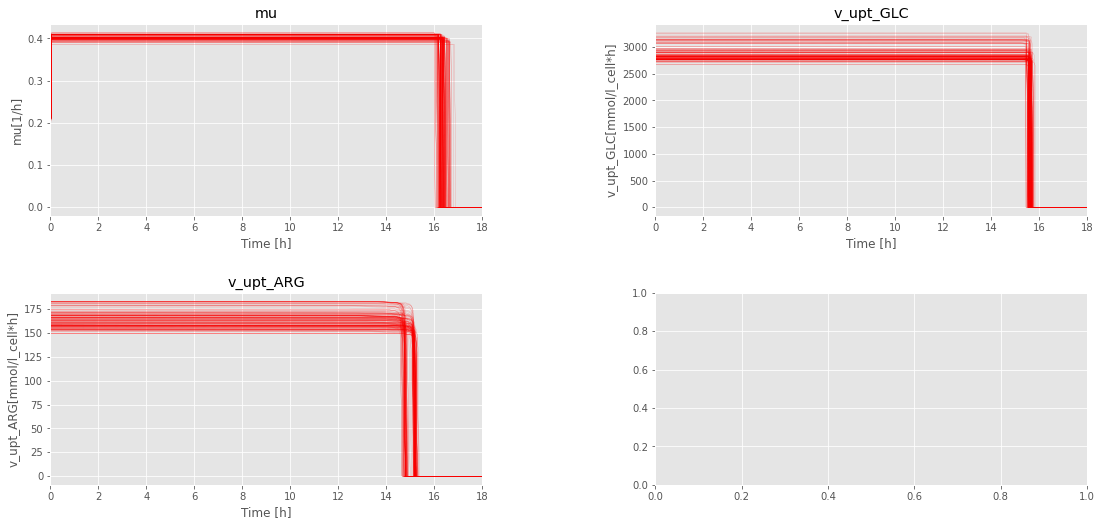

In [25]:
#Examplary for replicate 2
plot_rates(rep2)

## 7.5 Evaluate Rates and Uncertainties

In [26]:
# For Mean value calculateion remove non-dynmaic parts:
t_start   = 0.2
t_end     = 15.8


dL1_cut = []
dL2_cut = []
dL3_cut = []

for df in dL1_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dL1_cut.append(df)


for df in dL2_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dL2_cut.append(df)
    
for df in dL3_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dL3_cut.append(df)

In [27]:
# Create df with means and max over time
dL1_m   = {}
dL1_max = {}
dL2_m   = {}
dL2_max = {}
dL3_m   = {}
dL3_max = {}

# Use list of rate names as dict keys
rate_names = ['v_upt_GLC', 'v_upt_LEU', 'mu']

#Max for Rep1 in timepoints
i = 0 # iterator for the dict keys
for r in dL1_c:
    dL1_max[rate_names[i]] = r.max(axis=0)
    i+=1
dL1_max = pd.DataFrame(dL1_max)

#Mean for Rep1 over time
i = 0 # iterator for the dict keys
for r in dL1_cut:
    dL1_m[rate_names[i]]   = r.mean(axis=1)
    i+=1
dL1_m   = pd.DataFrame(dL1_m)

#MAX for Rep2
i=0 # reset iterator for the dict keys
for r in dL2_c:
    dL2_max[rate_names[i]] = r.max(axis=0)
    i+=1
dL2_max = pd.DataFrame(dL2_max)

#Mean for Rep2
i=0 # reset iterator for the dict keys
for r in dL2_cut:
    dL2_m[rate_names[i]]   = r.mean(axis=1)
    i+=1
dL2_m   = pd.DataFrame(dL2_m)    

#MAX for Rep3
i=0 # reset iterator for the dict keys
for r in dL3_c:
    dL3_max[rate_names[i]] = r.max(axis=0)
    i+=1
dL3_max = pd.DataFrame(dL3_max)

#Mean for Rep3
i=0 # reset iterator for the dict keys
for r in dL3_cut:
    dL3_m[rate_names[i]]   = r.mean(axis=1)
    i+=1
dL3_m   = pd.DataFrame(dL3_m)  

# Create df with mean and max over replicates
dL_mean = {}
dL_max  = {}
for key in dL2_m.keys():
    dL_mean[key] = np.mean([dL1_m[key].values,dL2_m[key].values,dL3_m[key].values],axis=0)
    dL_max[key]  = np.mean([dL1_max[key].values,dL2_max[key].values,dL3_max[key].values],axis=0)
dL_mean = pd.DataFrame(dL_mean, index=dL2_m.index)
dL_max  = pd.DataFrame(dL_max, index=dL2_max.index)

In [28]:
#Make readable DataFrame 
Eval_ind = ['lb', 'mean', 'ub']
Eval     = pd.DataFrame(np.zeros([3,len(dL_max.keys())]),index=Eval_ind, columns=dL_max.keys())
mEval    = pd.DataFrame(np.zeros([3,len(dL_mean.keys())]),index=Eval_ind, columns=dL_mean.keys())

for key in dL_max.keys():
    Eval.loc['lb'][key]   = dL_max[key].quantile(q=[0.16])
    Eval.loc['mean'][key] = dL_max[key].mean()
    Eval.loc['ub'][key]   = dL_max[key].quantile(q=[0.84])
for key in dL_mean.keys():
    mEval.loc['lb'][key]   = dL_mean[key].quantile(q=[0.16])
    mEval.loc['mean'][key] = dL_mean[key].mean()
    mEval.loc['ub'][key]   = dL_mean[key].quantile(q=[0.84])

In [29]:
mEval

,v_upt_GLC,v_upt_LEU
lb,5.537928,0.402339
mean,5.368469,0.401779
ub,5.538203,0.402344


In [30]:
Eval

,v_upt_GLC,v_upt_LEU
lb,5.320996,0.397033
mean,5.538205,0.402344
ub,5.902750,0.409265
